## <font color=#6B49F5> A Simple Implementation of FedAvg with PyTorch on IID Data </font> 
Please see https://towardsdatascience.com/federated-learning-a-simple-implementation-of-fedavg-federated-averaging-with-pytorch-90187c9c9577 for more details.

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import math
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt

from pathlib import Path
import requests
import pickle
import gzip

import torch
import math
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from datetime import datetime 
from datetime import date
import os
from CKA import CKA, CudaCKA

pd.options.display.float_format = "{:,.4f}".format

In [2]:
# Let's download data set
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
# PATH = os.join.path(p1, p2)
PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin-1")

In [4]:
# Let's see the dataset size
x_train.shape, y_train.shape , x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((50000, 784), (50000,), (10000, 784), (10000,), (10000, 784), (10000,))

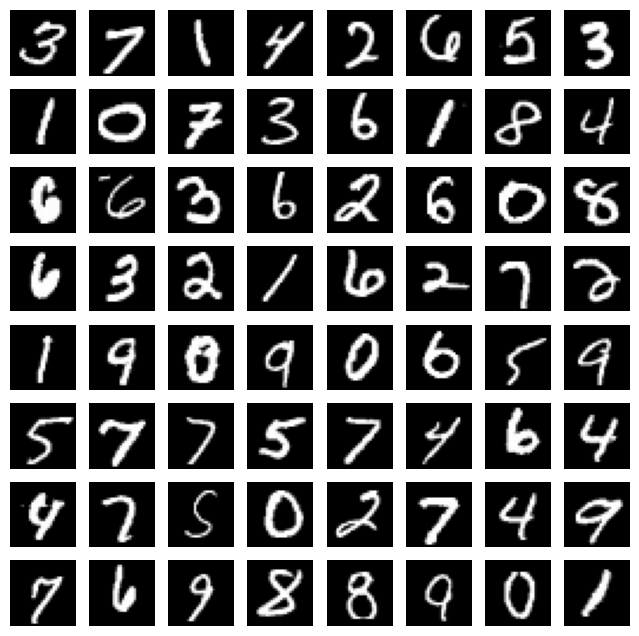

In [5]:
fig, axes = plt.subplots(8,8,figsize=(8,8))
for i in range(8):
    for j in range(8):
        num_index = np.random.randint(len(x_train))
        axes[i,j].imshow(x_train[num_index].reshape((28,28)), cmap="gray")
        axes[i,j].axis("off")
plt.show() 

**Let's check how many of each tag are**

In [6]:
# Let's check how many of each tag are.
y_train_total=0
y_valid_total=0
y_test_total=0
total=0
for i in range(10):
    print(i,">> train:", sum(y_train==i), ", valid:", sum(y_valid==i), 
          ", test:", sum(y_test==i), ", total:", sum(y_train==i)+sum(y_valid==i)+sum(y_test==i) )
    y_train_total=y_train_total + sum(y_train==i)
    y_valid_total=y_valid_total + sum(y_valid==i)
    y_test_total=y_test_total + sum(y_test==i)
    total=total+sum(y_train==i)+sum(y_valid==i)+sum(y_test==i)
    
print("y_train_total=", y_train_total) 
print("y_valid_total=", y_valid_total) 
print("y_test_total=", y_test_total)
print("total=", total)

0 >> train: 4932 , valid: 991 , test: 980 , total: 6903
1 >> train: 5678 , valid: 1064 , test: 1135 , total: 7877
2 >> train: 4968 , valid: 990 , test: 1032 , total: 6990
3 >> train: 5101 , valid: 1030 , test: 1010 , total: 7141
4 >> train: 4859 , valid: 983 , test: 982 , total: 6824
5 >> train: 4506 , valid: 915 , test: 892 , total: 6313
6 >> train: 4951 , valid: 967 , test: 958 , total: 6876
7 >> train: 5175 , valid: 1090 , test: 1028 , total: 7293
8 >> train: 4842 , valid: 1009 , test: 974 , total: 6825
9 >> train: 4988 , valid: 961 , test: 1009 , total: 6958
y_train_total= 50000
y_valid_total= 10000
y_test_total= 10000
total= 70000


In [7]:
def split_and_shuffle_labels(y_data, seed, amount):
    y_data=pd.DataFrame(y_data,columns=["labels"])
    y_data["i"]=np.arange(len(y_data))
    label_dict = dict()
    for i in range(10):
        var_name="label" + str(i)
        label_info=y_data[y_data["labels"]==i]
        np.random.seed(seed)
        label_info=np.random.permutation(label_info)
        label_info=label_info[0:amount]
        label_info=pd.DataFrame(label_info, columns=["labels","i"])
        label_dict.update({var_name: label_info })
    return label_dict

In [8]:
def get_iid_subsamples_indices(label_dict, number_of_samples, amount):
    sample_dict= dict()
    batch_size=int(math.floor(amount/number_of_samples))
    for i in range(number_of_samples):
        sample_name="sample"+str(i)
        dumb=pd.DataFrame()
        for j in range(10):
            label_name=str("label")+str(j)
            a=label_dict[label_name][i*batch_size:(i+1)*batch_size]
            dumb=pd.concat([dumb,a], axis=0)
        dumb.reset_index(drop=True, inplace=True)    
        sample_dict.update({sample_name: dumb}) 
    return sample_dict

In [9]:
def create_iid_subsamples(sample_dict, x_data, y_data, x_name, y_name):
    x_data_dict= dict()
    y_data_dict= dict()
    
    for i in range(len(sample_dict)):  ### len(sample_dict)= number of samples
        xname= x_name+str(i)
        yname= y_name+str(i)
        sample_name="sample"+str(i)
        
        indices=np.sort(np.array(sample_dict[sample_name]["i"]))
        
        x_info= x_data[indices,:]
        x_data_dict.update({xname : x_info})
        
        y_info= y_data[indices]
        y_data_dict.update({yname : y_info})
        
    return x_data_dict, y_data_dict

--------------------------
### <span style="background-color:#F087F9"> Classification Model </span> 

In [10]:
class Net2nn(nn.Module):
    def __init__(self):
        super(Net2nn, self).__init__()
        self.fc1=nn.Linear(784,200)
        self.fc2=nn.Linear(200,200)
        self.fc3=nn.Linear(200,10)
        
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [11]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [12]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0

    for data, target in train_loader:
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()
        

    return train_loss / len(train_loader), correct/len(train_loader.dataset)

In [13]:
def validation(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            
            test_loss += criterion(output, target).item()
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)

    return (test_loss, correct)

---------------------------------
### <span style="background-color:#F087F9"> Functions for Federated Averaging </span> 

In [14]:
def create_model_optimizer_criterion_dict(number_of_samples):
    model_dict = dict()
    optimizer_dict= dict()
    criterion_dict = dict()
    
    for i in range(number_of_samples):
        model_name="model"+str(i)
        model_info=Net2nn()
        model_dict.update({model_name : model_info })
        
        optimizer_name="optimizer"+str(i)
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum)
        optimizer_dict.update({optimizer_name : optimizer_info })
        
        criterion_name = "criterion"+str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name : criterion_info})
        
    return model_dict, optimizer_dict, criterion_dict 

In [15]:
def get_averaged_weights(model_dict, number_of_samples):
   
    fc1_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc1.weight.shape)
    fc1_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc1.bias.shape)
    
    fc2_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc2.weight.shape)
    fc2_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc2.bias.shape)
    
    fc3_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc3.weight.shape)
    fc3_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc3.bias.shape)
    
    with torch.no_grad():
    
    
        for i in range(number_of_samples):
            fc1_mean_weight += model_dict[name_of_models[i]].fc1.weight.data.clone()
            fc1_mean_bias += model_dict[name_of_models[i]].fc1.bias.data.clone()
        
            fc2_mean_weight += model_dict[name_of_models[i]].fc2.weight.data.clone()
            fc2_mean_bias += model_dict[name_of_models[i]].fc2.bias.data.clone()
        
            fc3_mean_weight += model_dict[name_of_models[i]].fc3.weight.data.clone()
            fc3_mean_bias += model_dict[name_of_models[i]].fc3.bias.data.clone()

        
        fc1_mean_weight =fc1_mean_weight/number_of_samples
        fc1_mean_bias = fc1_mean_bias/ number_of_samples
    
        fc2_mean_weight =fc2_mean_weight/number_of_samples
        fc2_mean_bias = fc2_mean_bias/ number_of_samples
    
        fc3_mean_weight =fc3_mean_weight/number_of_samples
        fc3_mean_bias = fc3_mean_bias/ number_of_samples
    
    return fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias

In [16]:
def set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples):
    fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias = get_averaged_weights(model_dict, number_of_samples=number_of_samples)
    with torch.no_grad():
        main_model.fc1.weight.data = fc1_mean_weight.data.clone()
        main_model.fc2.weight.data = fc2_mean_weight.data.clone()
        main_model.fc3.weight.data = fc3_mean_weight.data.clone()

        main_model.fc1.bias.data = fc1_mean_bias.data.clone()
        main_model.fc2.bias.data = fc2_mean_bias.data.clone()
        main_model.fc3.bias.data = fc3_mean_bias.data.clone() 
    return main_model

In [17]:
def compare_local_and_merged_model_performance(number_of_samples):
    accuracy_table=pd.DataFrame(data=np.zeros((number_of_samples,3)), columns=["sample", "local_ind_model", "merged_main_model"])
    for i in range (number_of_samples):
    
        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        individual_loss, individual_accuracy = validation(model, test_dl, criterion)
        main_loss, main_accuracy =validation(main_model, test_dl, main_criterion )
    
        accuracy_table.loc[i, "sample"]="sample "+str(i)
        accuracy_table.loc[i, "local_ind_model"] = individual_accuracy
        accuracy_table.loc[i, "merged_main_model"] = main_accuracy

    return accuracy_table

In [18]:
def send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples):
    with torch.no_grad():
        for i in range(number_of_samples):

            model_dict[name_of_models[i]].fc1.weight.data =main_model.fc1.weight.data.clone()
            model_dict[name_of_models[i]].fc2.weight.data =main_model.fc2.weight.data.clone()
            model_dict[name_of_models[i]].fc3.weight.data =main_model.fc3.weight.data.clone() 
            
            model_dict[name_of_models[i]].fc1.bias.data =main_model.fc1.bias.data.clone()
            model_dict[name_of_models[i]].fc2.bias.data =main_model.fc2.bias.data.clone()
            model_dict[name_of_models[i]].fc3.bias.data =main_model.fc3.bias.data.clone() 
    
    return model_dict

In [19]:
def start_train_end_node_process(number_of_samples):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

#         valid_ds = TensorDataset(x_valid_dict[name_of_x_valid_sets[i]], y_valid_dict[name_of_y_valid_sets[i]])
#         valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)
        
        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        print("Subset" ,i)
        for epoch in range(numEpoch):        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
#             valid_loss, valid_accuracy = validation(model, valid_dl, criterion)
            test_loss, test_accuracy = validation(model, test_dl, criterion)
    
            print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))

In [20]:

def start_train_end_node_process_without_print(number_of_samples, sample_list, iteration):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        for epoch in range(numEpoch):        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion)
            
        for sample in sample_list:
            plot_node_weights(model_dict, sample[0], sample[1], iteration)

In [21]:
def start_train_end_node_process_print_some(number_of_samples, print_amount, sample_list, iteration):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        if i<print_amount:
            print("Subset" ,i)
            
        for epoch in range(numEpoch):
        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion)
            
            if i<print_amount:        
                print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy)) 
        for sample in sample_list:
            plot_node_weights(model_dict, sample[0], sample[1], iteration)

In [22]:
## Add visualization code

In [44]:
def plot_node_weights(model_dict, layer, selected_weight, iteration, file_location="Plots/"):
    # create an array of the weight values|
    sample_weights = []
    for i in range (number_of_samples):
        current_model = "model" + str(i)
        w_local = getattr(model_dict[current_model], layer).weight[selected_weight[0],selected_weight[1]].detach().numpy()

        sample_weights.append(w_local.tolist())


    num_bins = int(number_of_samples/4)

    # process the data with GaussianMixture model
    sample_weights = np.asarray(sample_weights)
    sample_weights = sample_weights.reshape(len(sample_weights), 1)


    # Create a histgram
    fig, ax = plt.subplots()
    

    n, bins, patches = plt.hist(sample_weights, num_bins, 
                            density = 1, 
                            color ='orange',
                            alpha = 0.7)
    
    mu = np.mean(sample_weights)
    fig.set_facecolor("lightgray")
    plt.axvline(mu, color='blue', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    # plt.text(mu, max_ylim, 'Mean: {:.6f}'.format(mu))

    plt.suptitle('Layer of: ' + layer + ', Random Weight: ' +  str(selected_weight) + ', Iter ' + str(iteration))
    ax.set_title('Mean: {:.6f}'.format(mu))
    # create a time stamp
    today = date.today().strftime('%Y%m%d')
    now = datetime.now()
    current_time = now.strftime("%H-%M-%S")
    
    # plt.show() 
    plt_name = layer + "_" + str(selected_weight[0]) + "_" + str(selected_weight[1]) + "_I_" + \
    str(iteration) + "_" + str(today) + "_" + str(current_time) + ".png"
    
    node_folder = file_location + layer + "_" + str(selected_weight[0]) + "_" + str(selected_weight[1])
    
    if not os.path.exists(node_folder):
        os.makedirs(node_folder)
    
    plt.savefig(node_folder + '/' + plt_name)
    plt.close()

In [24]:
# random sampling based on parameters
def random_sampling_nodes(model, each_layer_sample_num):
    layers = []
    for name, layer in model.named_modules():
        if name != "":
            dnn_layer = getattr(model, name)
            layers.append([name, [dnn_layer.weight.size()[0], dnn_layer.weight.size()[1]]])
    # print(*layers,sep='\n')
    
    if len(each_layer_sample_num)!=len(layers):
        print("each_layer_sample_num list's length not equal to model layer list")
        return(-1)
    else:
        weights_sample = []
        for i in range(len(layers)):
            for j in range (each_layer_sample_num[i]):
                random_weight = [np.random.randint(layers[i][1][0]), np.random.randint(layers[i][1][1])]
                # print("random_weight:", random_weight)
                weights_sample.append([layers[i][0], random_weight])
    return weights_sample

In [25]:
x_train, y_train, x_valid, y_valid,x_test, y_test = map(torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test))
number_of_samples=100
learning_rate = 0.01
numEpoch = 10
batch_size = 32
momentum = 0.9

train_amount=4500
valid_amount=900
test_amount=900
print_amount=3

device = torch.device('cuda:0')
cuda_cka = CudaCKA(device)

----------------

### <span style="background-color:#F087F9"> Let's examine what would the performance of the centralized model be if the data were not distributed to nodes at all? </span>   

The model used in this example is very simple, different things can be done to improve model performance, such as using more complex models, increasing epoch or hyperparameter tuning. However, the purpose here is to compare the performance of the main model that is formed by combining the parameters of the local models trained on their own data with a centralized model that trained on all training data. In this way, we can gain insight into the capacity of federated learning.


In [26]:
centralized_model = Net2nn()
centralized_optimizer = torch.optim.SGD(centralized_model.parameters(), lr=0.01, momentum=0.9)
centralized_criterion = nn.CrossEntropyLoss()

In [27]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

In [28]:
print("------ Centralized Model ------")
for epoch in range(numEpoch):
    central_train_loss, central_train_accuracy = train(centralized_model, train_dl, centralized_criterion, centralized_optimizer)
    central_test_loss, central_test_accuracy = validation(centralized_model, test_dl, centralized_criterion)
    
    print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.4f}".format(central_train_accuracy) + " | test accuracy: {:7.4f}".format(central_test_accuracy))

print("------ Training finished ------")

------ Centralized Model ------
epoch:   1 | train accuracy:  0.8773 | test accuracy:  0.9483
epoch:   2 | train accuracy:  0.9561 | test accuracy:  0.9623
epoch:   3 | train accuracy:  0.9694 | test accuracy:  0.9714
epoch:   4 | train accuracy:  0.9780 | test accuracy:  0.9714
epoch:   5 | train accuracy:  0.9832 | test accuracy:  0.9746
epoch:   6 | train accuracy:  0.9870 | test accuracy:  0.9756
epoch:   7 | train accuracy:  0.9897 | test accuracy:  0.9756
epoch:   8 | train accuracy:  0.9913 | test accuracy:  0.9750
epoch:   9 | train accuracy:  0.9940 | test accuracy:  0.9791
epoch:  10 | train accuracy:  0.9960 | test accuracy:  0.9793
------ Training finished ------



----------------
-----------------
**Data is distributed to nodes**

<!-- ### <span style="background-color:#F087F9"> Datanın nodelara dağıtılması </span>    -->

In [29]:
label_dict_train=split_and_shuffle_labels(y_data=y_train, seed=1, amount=train_amount) 
sample_dict_train=get_iid_subsamples_indices(label_dict=label_dict_train, number_of_samples=number_of_samples, amount=train_amount)
x_train_dict, y_train_dict = create_iid_subsamples(sample_dict=sample_dict_train, x_data=x_train, y_data=y_train, x_name="x_train", y_name="y_train")


label_dict_valid = split_and_shuffle_labels(y_data=y_valid, seed=1, amount=train_amount) 
sample_dict_valid = get_iid_subsamples_indices(label_dict=label_dict_valid, number_of_samples=number_of_samples, amount=valid_amount)
x_valid_dict, y_valid_dict = create_iid_subsamples(sample_dict=sample_dict_valid, x_data=x_valid, y_data=y_valid, x_name="x_valid", y_name="y_valid")

label_dict_test = split_and_shuffle_labels(y_data=y_test, seed=1, amount=test_amount) 
sample_dict_test = get_iid_subsamples_indices(label_dict=label_dict_test, number_of_samples=number_of_samples, amount=test_amount)
x_test_dict, y_test_dict = create_iid_subsamples(sample_dict=sample_dict_test, x_data=x_test, y_data=y_test, x_name="x_test", y_name="y_test")

torch.Size([450, 784]) torch.Size([450])
torch.Size([90, 784]) torch.Size([90])
torch.Size([90, 784]) torch.Size([90])
tensor(1)


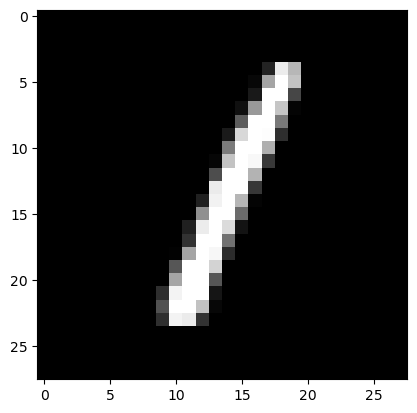

In [30]:
print(x_train_dict["x_train1"].shape, y_train_dict["y_train1"].shape)
print(x_valid_dict["x_valid1"].shape, y_valid_dict["y_valid1"].shape) 
print(x_test_dict["x_test1"].shape, y_test_dict["y_test1"].shape)

num_index = np.random.randint(test_amount/number_of_samples*10)
plt.imshow(x_test_dict["x_test0"][num_index].reshape((28,28)), cmap="gray")
print(y_test_dict["y_test0"][num_index])

**Main model is created**

In [31]:
main_model = Net2nn()
main_optimizer = torch.optim.SGD(main_model.parameters(), lr=learning_rate, momentum=0.9)
main_criterion = nn.CrossEntropyLoss()

**Models,optimizers and loss functions in nodes are defined**

In [32]:
model_dict, optimizer_dict, criterion_dict = create_model_optimizer_criterion_dict(number_of_samples)

**Keys of dicts are being made iterable**

In [33]:
name_of_x_train_sets=list(x_train_dict.keys())
name_of_y_train_sets=list(y_train_dict.keys())
name_of_x_valid_sets=list(x_valid_dict.keys())
name_of_y_valid_sets=list(y_valid_dict.keys())
name_of_x_test_sets=list(x_test_dict.keys())
name_of_y_test_sets=list(y_test_dict.keys())

name_of_models=list(model_dict.keys())
name_of_optimizers=list(optimizer_dict.keys())
name_of_criterions=list(criterion_dict.keys())

# print(name_of_x_train_sets)
# print(name_of_y_train_sets)
# print(name_of_x_valid_sets)
# print(name_of_y_valid_sets)
# print(name_of_x_test_sets)
# print(name_of_y_test_sets)
# print("\n ------------")
# print(name_of_models)
# print(name_of_optimizers)
# print(name_of_criterions)

In [34]:
print(main_model.fc2.weight[0:1,0:5])
print(model_dict["model1"].fc2.weight[0:1,0:5])

tensor([[ 0.0224, -0.0141,  0.0389,  0.0361, -0.0590]],
       grad_fn=<SliceBackward0>)
tensor([[ 0.0437,  0.0172,  0.0558,  0.0171, -0.0324]],
       grad_fn=<SliceBackward0>)


**Parameters of main model are sent to nodes**  
Since the parameters of the main model and parameters of all local models in the nodes are randomly initialized, all these parameters will be different from each other. For this reason, the main model sends its parameters to the nodes before the training of local models in the nodes begins. You can check the weights below.

In [35]:
model_dict=send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)

In [36]:
print(main_model.fc2.weight[0:1,0:5])
print(model_dict["model1"].fc2.weight[0:1,0:5])

tensor([[ 0.0224, -0.0141,  0.0389,  0.0361, -0.0590]],
       grad_fn=<SliceBackward0>)
tensor([[ 0.0224, -0.0141,  0.0389,  0.0361, -0.0590]],
       grad_fn=<SliceBackward0>)


In [37]:
each_layer_list = [0,0,1]

In [38]:
sample_t = random_sampling_nodes(main_model, each_layer_list)

In [39]:
sample_t

[['fc3', [2, 106]]]

**Models in the nodes are trained**

In [45]:
# start_train_end_node_process()
start_train_end_node_process_print_some(number_of_samples, print_amount, sample_t, 1)

Subset 0
epoch:   1 | train accuracy: 0.96889 | test accuracy: 0.84444
epoch:   2 | train accuracy: 0.98444 | test accuracy: 0.82222
epoch:   3 | train accuracy: 0.98889 | test accuracy: 0.83333
epoch:   4 | train accuracy: 0.98444 | test accuracy: 0.84444
epoch:   5 | train accuracy: 0.99333 | test accuracy: 0.84444
epoch:   6 | train accuracy: 0.99111 | test accuracy: 0.83333
epoch:   7 | train accuracy: 0.94889 | test accuracy: 0.77778
epoch:   8 | train accuracy: 0.96889 | test accuracy: 0.85556
epoch:   9 | train accuracy: 0.98222 | test accuracy: 0.85556
epoch:  10 | train accuracy: 0.99556 | test accuracy: 0.84444
Subset 1
epoch:   1 | train accuracy: 0.11556 | test accuracy: 0.21111
epoch:   2 | train accuracy: 0.26000 | test accuracy: 0.43333
epoch:   3 | train accuracy: 0.46889 | test accuracy: 0.54444
epoch:   4 | train accuracy: 0.56222 | test accuracy: 0.53333
epoch:   5 | train accuracy: 0.57556 | test accuracy: 0.60000
epoch:   6 | train accuracy: 0.68667 | test accuracy

KeyboardInterrupt: 

In [ ]:
## As you can see, wieghts of local models are updated after training process
print(main_model.fc2.weight[0,0:5])
print(model_dict["model1"].fc2.weight[0,0:5])

### Let's compare the performance of federated main model, individual local models and centralized model  

**Federated main model vs individual local models before 1st iteration (on distributed test set)**  
Since main model is randomly initialized and no action taken on it yet, its performance is very poor. Please before_acc_table

In [ ]:
before_acc_table=compare_local_and_merged_model_performance(number_of_samples=number_of_samples)
before_test_loss, before_test_accuracy = validation(main_model, test_dl, main_criterion)

main_model= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples) 

after_acc_table=compare_local_and_merged_model_performance(number_of_samples=number_of_samples)
after_test_loss, after_test_accuracy = validation(main_model, test_dl, main_criterion)

In [ ]:
print("Federated main model vs individual local models before FedAvg first iteration")
before_acc_table.head()

In [ ]:
print("Federated main model vs individual local models after FedAvg first iteration")
after_acc_table.head()

**Federated main model vs centralized model before 1st iteration (on all test data)**  
Please be aware that the centralized model gets approximately %98 accuracy on all test data.

In [ ]:
print("Before 1st iteration main model accuracy on all test data: {:7.4f}".format(before_test_accuracy))
print("After 1st iteration main model accuracy on all test data: {:7.4f}".format(after_test_accuracy))
print("Centralized model accuracy on all test data: {:7.4f}".format(central_test_accuracy))

This is a single iteration, we can send the weights of the main model back to the nodes and repeat the above steps.
Now let's check how the performance of the main model improves when we repeat the iteration 10 more times.

In [ ]:
for i in range(9):
    model_dict=send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)
    start_train_end_node_process_without_print(number_of_samples, sample_t, i+2)
    main_model= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples) 
    test_loss, test_accuracy = validation(main_model, test_dl, main_criterion)
    print("Iteration", str(i+2), ": main_model accuracy on all test data: {:7.4f}".format(test_accuracy))   

The accuracy of the centralized model was calculated as approximately 98%. The accuracy of the main model obtained by FedAvg method started from 85% and improved to 94%. In this case, we can say that although the main model obtained by FedAvg method was trained without seeing the data, its performance cannot be underestimated.

In [ ]:
# create video
from moviepy.editor import *

In [ ]:
def images_to_video(image_folder_path: str, fps, extension:str, video_name:str, output_format:str):
    
    import os
    import moviepy.video.io.ImageSequenceClip
    
    images = [image_folder_path+'/'+img for img in os.listdir(image_folder_path) if img.endswith(extension)]
    movie_clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(images, fps)
    movie_clip.write_videofile(video_name+output_format,codec="libx264")

In [ ]:
sample_t

In [ ]:
for s in sample_t:
    node_name = s[0]+"_"+ str(s[1][0])+"_"+str(s[1][1])
    images_to_video("Plots/" + str(node_name), 24, ".png", node_name, ".mp4")

In [87]:
node_name = "fc2_21_67"

In [88]:
images_to_video("Plots/" + str(node_name), 24, ".png", node_name, ".mp4")

Moviepy - Building video fc2_21_67.mp4.
Moviepy - Writing video fc2_21_67.mp4



Moviepy - Done !
Moviepy - video ready fc2_21_67.mp4
